## Rechnerübung zur Vorlesung "Algorithmen der Bioinformatik I"

Das folgende Jupyter notebook enthält die Lösungen zur ersten Rechnerübung der Veranstaltung "Algorithmen der Bioinformatik I".

Zur Beantwortung der Fragen wird die `bio_algos` Anwendung genutzt. Der Quelltext der Anwendung befindet sich in dem übergeordneten Ordner, eine Kopie der Binary in dem Ordner des notebooks.


Autor: Robin Hundt

Die verschiedenen Möglichkeiten der `bio_algos` Kommandozeilenanwendug können über das Hilfsflag `-h` erkundet werden.

In [106]:
# Generelle Hilfsinformation
!./bio_algos -h

Bio-Algorithms 0.1.0
Robin William Hundt
A program implementing some bio algorithmic stuff.

USAGE:
    bio_algos [SUBCOMMAND]

FLAGS:
    -h, --help       Prints help information
    -V, --version    Prints version information

SUBCOMMANDS:
    calc_pwm                Calculates a position weight matrix for the input
    calc_roc                Calculates a ROC curve given the inout sequences and the pwm matrix
    calc_threshold          Calculates a score threshold give a sensitivity and an optional pwm matrix
    count_startcodons       Counts all possible startcodon variants in the input
    eval_sequences          Evaluates the input sequences given the provided pwm and a threshold
    help                    Prints this message or the help of the given subcommand(s)
    pseudocount_auc_data    This command will evaluate a range of pseudocount and output the AUC of resultig rocs


In [107]:
# matplotlib ist die einzige Python dependency
import matplotlib.pyplot as plt
%matplotlib inline

import json

def plot(filename, x_label='False Negative Rate', y_label='True Positive Rate'):
    with open(filename) as f:
        data = json.load(f)
    plt.figure(figsize=(4,4), dpi=150)
    x_data, y_data = list(zip(*data))
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.plot(x_data, y_data)

### Wie viele mögliche Kandidaten für die verschiedenen Startcodon-Varianten gibt es insgesamt?

Über das Subkommando `count_startcodons` können die Startcodonvarianten in den Inputsequenzen gezählt werden.

In [108]:
!./bio_algos count_startcodons -h

bio_algos-count_startcodons 
Counts all possible startcodon variants in the input

USAGE:
    bio_algos count_startcodons <INPUT>

FLAGS:
    -h, --help       Prints help information
    -V, --version    Prints version information

ARGS:
    <INPUT>    Input sequence data


In [109]:
!./bio_algos count_startcodons data/cleaned-TIS-Ecoli.txt

Results:
{TTG: 2364, ATG: 2738, GTG: 1923}


Insgesamt tauchen die Startcodonvariationen 7025 Mal auf.

### Wählen Sie die Schwelle $t$ zunächst so, dass 50% der richtigen Kandidaten erkannt werden. Wie hoch ist der Fehler, d.h. wie viele der falschen Kandidaten detektieren Sie damit zwangsläufig auch?

Das Subkommando `calc_threshold` erlaubt es dem Anwender den Detektionsschwellwert zu berechnen welcher benötigt wird um die spezifizierte Sensitivität (TPR) auf den Inputdaten zu erreichen.  
Optional kann der Pfad zu einer PWM spezifiziert werden, wird keine angegeben, wird eine PWM mit folgenden Standardparametern erstellt:  
- Länge: 30
- Hintergrundmodell: 0,25 0,25 0,25 0,25 (A, C, G, T)
- TIS Position (0 basierter Index): 100
- Pseudocount: 1,0

In [110]:
!./bio_algos calc_threshold -h

bio_algos-calc_threshold 
Calculates a score threshold give a sensitivity and an optional pwm matrix

USAGE:
    bio_algos calc_threshold [OPTIONS] <INPUT>

FLAGS:
    -h, --help       Prints help information
    -V, --version    Prints version information

OPTIONS:
        --pwm <PATH>                   Position weight matrix for given sequence data
        --sensitivity <sensitivity>    Sensitivity to achieve with threshold. [default: 0.50]
        --tis <POS>                    Position of the aligned translation initiation site [default: 100]

ARGS:
    <INPUT>    Input sequence data


In [111]:
!./bio_algos calc_threshold --sensitivity 0.5 data/cleaned-TIS-Ecoli.txt

Acvieved sensitivity of 0.5006934812760055 with threshold: 3.051580765008849
FP: 137, TP: 361, FPR: 0.0263360246059208, TPR: 0.5006934812760055


Die leicht höhere Sensitivität kommt dadurch zustande, dass in dem cleaned dataset der Fehler in Sequenz 304 bereinigt wurde, indem die Sequenz entfernt wurde.

### Unterteilung der Daten in Trainings- und Testmenge

In [112]:
!head -n 400 data/cleaned-TIS-Ecoli.txt > data/training-TIS-Ecoli.txt
!tail -n 321 data/cleaned-TIS-Ecoli.txt > data/test-TIS-Ecoli.txt

### Schätzen der PWM Parameter und des Detektionsschwellwertes auf den Trainingsdaten

Zum Erzeugen einer position weight matrix kann das Subkommando `calc_pwm` verwendet werden.

In [113]:
!./bio_algos calc_pwm -h

bio_algos-calc_pwm 
Calculates a position weight matrix for the input

USAGE:
    bio_algos calc_pwm [OPTIONS] <INPUT>

FLAGS:
    -h, --help       Prints help information
    -V, --version    Prints version information

OPTIONS:
        --background <A> <C> <G> <T>    Specify a background model to use for the pwm [default: estimate background
                                        distribution of wrong sites]
    -L, --length <LENGTH>               Length of the pwm [default: 30]
        --offset <COUNT>
            Offset of the pwm window. A positive value will move the pwm to the right, over the tis site, a negative
            value in the other direction [default: 0]
    -o, --output <PATH>                 Where to store the pwm
        --pseudocount <COUNT>           Pseudocount to use for the pwm [default: 1.0]
        --tis <POS>                     Position of the aligned translation initiation site [default: 100]

ARGS:
    <INPUT>    Input sequence data


In [114]:
!./bio_algos calc_pwm -o default.pwm data/training-TIS-Ecoli.txt \
    --background 0.25 0.25 0.25 0.25
!./bio_algos calc_threshold --pwm default.pwm --sensitivity 0.5 \
    data/training-TIS-Ecoli.txt

Stored pwm at: default.pwm
Acvieved sensitivity of 0.5 with threshold: 2.952815669017548
FP: 90, TP: 200, FPR: 0.030040053404539385, TPR: 0.5


### Erkennungsrate auf den Testdaten

Zur Evaluierung der PWM kann das `eval_sequences` Subkommando verwendet werden.  
Es wird die Anzahl der False Positives, der True Positives, sowie deren jeweiligen Raten ausgegeben. 

In [115]:
!./bio_algos eval_sequences -h

bio_algos-eval_sequences 
Evaluates the input sequences given the provided pwm and a threshold

USAGE:
    bio_algos eval_sequences [OPTIONS] <INPUT> -t <threshold>

FLAGS:
    -h, --help       Prints help information
    -V, --version    Prints version information

OPTIONS:
        --pwm <PATH>      Position weight matrix for given sequence data
    -t <threshold>        Threshold to use for evalutaion

ARGS:
    <INPUT>    Input sequence data


In [116]:
!./bio_algos eval_sequences --pwm default.pwm -t 2.952815669017548 \
    data/test-TIS-Ecoli.txt

FP: 53, TP: 159, FPR: 0.02402538531278332, TPR: 0.07207615593834996


### Ermittlung des AUC Wert und plotten der zugrunde liegenden ROC Kurve

Um die Detektionsgenauigkeit unabhängig vom Schwellwert zu evaulieren kann eine Receiver Operating Characteristic (ROC) Kurve und die Fläche unter dieser (AUC) verwendet werden.  
Das `calc_roc` Subkommando berechnet die Punkte der ROC Kurve und gibt den AUC Wert aus sofern der `--auc` Flag gesetzt ist.

In [117]:
!./bio_algos calc_roc -h

bio_algos-calc_roc 
Calculates a ROC curve given the inout sequences and the pwm matrix

USAGE:
    bio_algos calc_roc [FLAGS] [OPTIONS] <INPUT>

FLAGS:
        --auc        Output the AUC for the curce
    -h, --help       Prints help information
    -V, --version    Prints version information

OPTIONS:
    -o, --output <PATH>    Where to store the pwm
        --pwm <PATH>       Position weight matrix for given sequence data

ARGS:
    <INPUT>    Input sequence data


In [118]:
!./bio_algos calc_roc --pwm default.pwm --auc -o default.roc \
    data/test-TIS-Ecoli.txt

AUC: 0.895529891572972


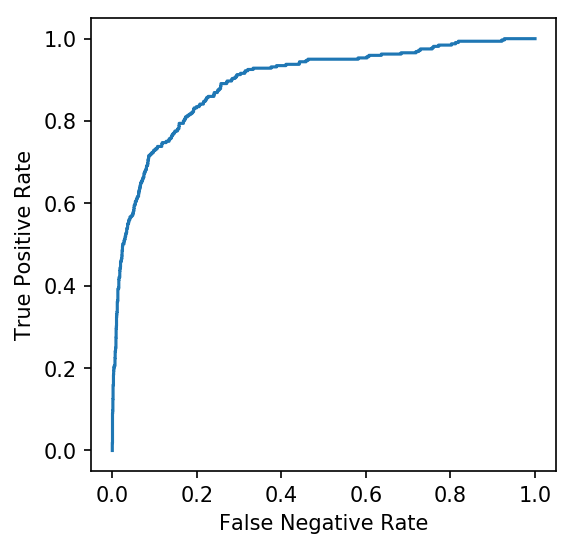

In [119]:
plot('default.roc')

### Ermittlung des AUC Wertes bei einem Offset von 1 

Stored pwm at: offset_1.pwm
AUC: 0.9484555008571858


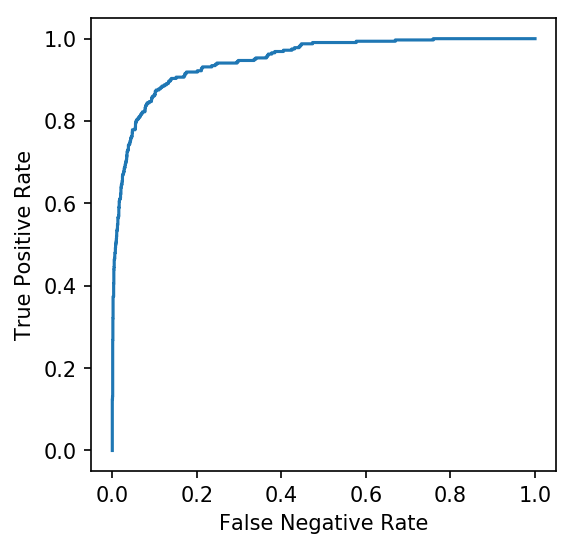

In [120]:
!./bio_algos calc_pwm -o offset_1.pwm data/training-TIS-Ecoli.txt \
    --offset 1 --background 0.25 0.25 0.25 0.25
!./bio_algos calc_roc --pwm offset_1.pwm --auc -o offset_1.roc \
    data/test-TIS-Ecoli.txt
plot('offset_1.roc')

Das Verwenden eines Offsets von 1, die erste Base des Startcodons wird also mitbetrachtet in der PWM, führt zu einer Verbesserung des AUC Wertes von ~0.05. Diese Verbesserung wird vermutlich dadurch verursacht, dass die Verteilung der verschiedenen Startcodonvarianten für die echten TIS und die falschen sich deutlich unterscheidet (über 90% der echten Startcodons sind ATG) und diese Information sich in der letzten Spalte der PWM wiederspiegelt. 

### Was könnte man mit Blick auf die Startcodon-Varianten als Nachteil dieser Erweiterung sehen? 
Da es keine Startcodonvariante gibt welche mit der Base C anfängt, für diese jedoch an allen Positionen der Pseudocount addiert wird, befindet sich an der Stelle der PWM welche der ersten Base des Startcodons entspricht ein Gewicht $>-\infty$. Dies entspricht nicht unserer Vorraussetzung dass lediglich die Startcodonvarianten ATG, GTG, TTG vorkommen.  
In der Praxis hat dies jedoch keine negativen Auswirkungen, da sich zwar die relativen Häufigkeiten der Basen A, G, T an der entsprechenden Position ändern, jedoch nicht ihre Sortierung nach Gewicht. 

### Verwendung verschiedener Pseudocounts

Die `bio_algos` Anwendung bietet mit dem Subkommando `pseudocount_auc_data` die Möglichkeit ein Intervall an verschiedenen Pseudocounts hinsichtlich des AUC Wertes zu evaluieren.

Im Folgenden ein Plot des AUC für einen Pseudocount von 0,0 - 20,0 in Schritten von 0,05. Hintergrundmodell ist die Gleichverteilung, kein Offset.

Anmerkung: Ob man dies machen sollte ist fragwürdig, da man hierdurch den Hyperparameter Pseudocount an seine Testdaten anpasst. Hier eignet es sich aber gut um den Einfluss des Pseudocounts darzustellen.

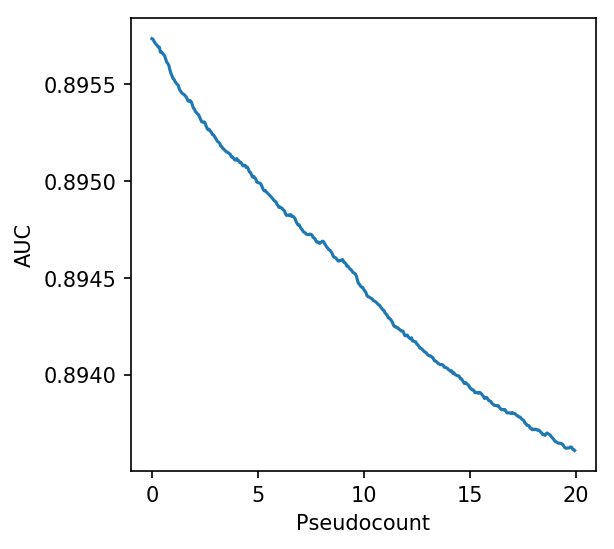

In [121]:
!./bio_algos pseudocount_auc_data -o '0.0-20.0.ac' --count_start 0 --count_end 20 \
    --count_step 0.05 --background 0.25 0.25 0.25 0.25  \
    data/training-TIS-Ecoli.txt data/test-TIS-Ecoli.txt
plot('0.0-20.0.ac', y_label='AUC', x_label='Pseudocount')

Betrachten wir die Werte im Intervall $[0.1, 1.0]$ näher, erkennen wir, dass auf diesen Daten ein Pseudocount von 0,0 marginal besser ist als 0,05.

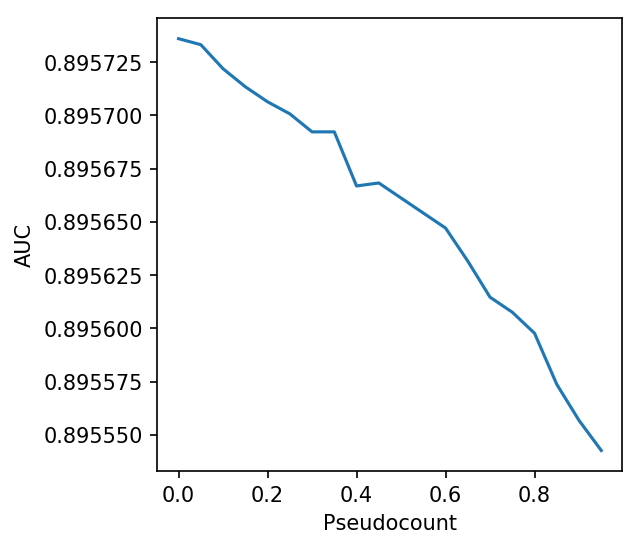

In [122]:
!./bio_algos pseudocount_auc_data -o '0.0-1.0.ac' --count_start 0 --count_end 1 \
    --count_step 0.05  --background 0.25 0.25 0.25 0.25 \
    data/training-TIS-Ecoli.txt data/test-TIS-Ecoli.txt
plot('0.0-1.0.ac', y_label='AUC', x_label='Pseudocount')

Ein ähnliches Bild bietet sich bei der Verwendung eines Offsets von 1.

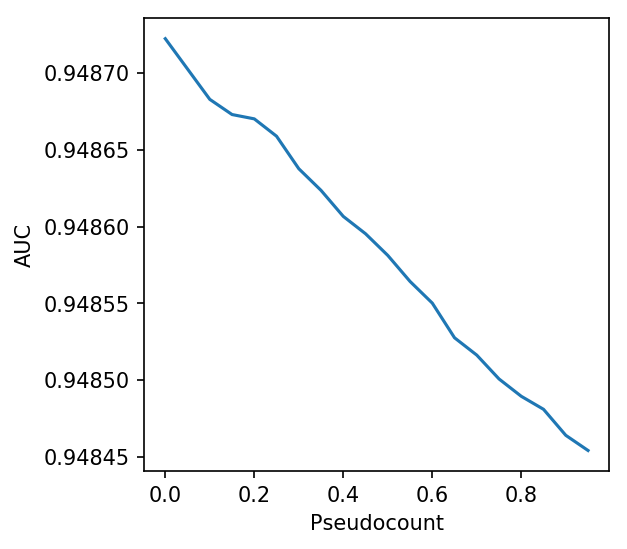

In [123]:
!./bio_algos pseudocount_auc_data -o '0.0-1.0.ac' --count_start 0 --count_end 1 \
    --count_step 0.05  --background 0.25 0.25 0.25 0.25 --offset 1 \
    data/training-TIS-Ecoli.txt data/test-TIS-Ecoli.txt
plot('0.0-1.0.ac', y_label='AUC', x_label='Pseudocount')

Auch wenn die Daten nahelegen auf einen Pseudocount zu verzichten, kann dieser in der Praxis dennoch sinnvoll sein. Bei einem Pseudocount von 0,0 haben potenzielle TIS bei denen eine Base an einer Stelle vorkommt die in den Trainingsdaten an dieser nie gesehen wurde automatisch ein Gewicht von $-\infty$, auch wenn die Basen an den anderen Positionen perfekt zur PWM passen.

### Schätzen der Hintergrundwahrscheinlichkeiten

Um das Modell zu verbessern versuchen wir die Hintergrundwahrscheinlichkeiten der Basen im Bereich der falschen Kandidaten zu schätzen anstatt eine uniforme Verteilung anzunehmen.  
Dies kann erreicht werden indem das Vorkommen der verschiedenen Basen in einem Fenster der Länge $L$ vor den falschen TIS gezählt wird und die relativen Häufigkeiten berechnet werden.

Stored pwm at: offset-1_pseudo-0.1_est-bg.pwm
AUC: 0.9522090701372286


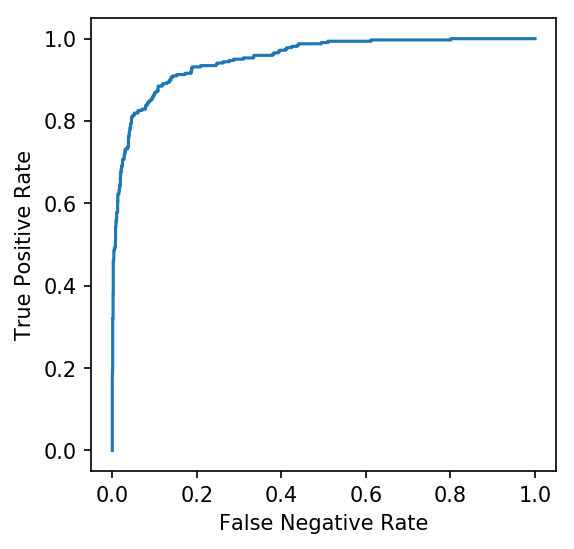

In [124]:
!./bio_algos calc_pwm --offset 1 --pseudocount 0.01 -o 'offset-1_pseudo-0.1_est-bg.pwm' \
    data/training-TIS-Ecoli.txt
!./bio_algos calc_roc --auc --pwm 'offset-1_pseudo-0.1_est-bg.pwm' -o 'offset-1_pseudo-0.1_est-bg.roc' \
    data/test-TIS-Ecoli.txt
plot('offset-1_pseudo-0.1_est-bg.roc')

Bei der Verwendung eines Pseudocounts von 0.01, eines Offsets von 1 und dem Schätzen der Hintergrundwahrscheinlichkeiten der Basen der falschen Kandidaten kann ein AUC Wert von ~0,9522 erreicht werden.

### Wie könnte über die hier untersuchten Möglichkeiten hinausgehend eine generelle Verfeinerung oder Erweiterung des PWM-Modells aussehen?

Anstatt einzelne Nukleotide zu betrachten können die Häufigketen von Dinukleotiden an den jeweiligen Positionen zur Berechnung einer Gewichtsmatrix verwendet werden. Diese hätte anstatt $4\times L$ eine Dimension von $16\times L-1$.

Qulle: Naum I. Gershenzon, Gary D. Stormo, Ilya P. Ioshikhes; Computational technique for improvement of the position-weight matrices for the DNA/protein binding sites, Nucleic Acids Research, Volume 33, Issue 7, 1 January 2005, Pages 2290–2301, https://doi.org/10.1093/nar/gki519

### Wir haben bei dem bisherigen Setup alle Startcodon-Kandidaten auf der linken bzw. rechten Seite des tatsächlichen Startcodons in der Mitte als falsche Kandidaten angenommen. Ist diese Annahme immer korrekt?

Dies hängt ganz und gar von den Daten ab. Für das Training und die Evaluation einer PWM gehen wir davon aus, dass wir die *wahren* und *falschen* TIS kennen. In unserem Datensatz waren die wahren TIS auf die Position 101 fixiert und es befanden sich (hoffentlich) keine weiteren wahren TIS an anderen Stellen der Sequenzen. Sollte dies der Fall sein, war das Labelling falsch und es hätte in dem Datensatz angegeben sein müssen an welchen Stellen genau die TIS vorkommen.  

### Wie müsste ein verbessertes Setup theoretisch aussehen, das insbesondere auch Stopcodons berücksichtigt?

Anstatt den Bereich vor jedem potenzielle Startcodon zu untersuchen, könnte man die Positionen von Stopcodons identifizieren, von diesen ausgehend nach links gehen und für jedes gefundene mögliche TIS den Score berechnen, solange bis man auf ein weiteres Stopcodon trifft oder die Sequenz zu Ende ist. Da hierbei mehrere potenzielle TIS links eines Stopcodons identifiziert werden könnten, könnte es sinnvoll sein die Scores der möglichen TIS zu skalieren mit dem Wert der Normalverteilung ( $\mu = E($Länge der codierenden Bereiche$)$ ) an der Stelle welche der Länge des potenziell codierenden Bereich entspricht.  
Der Erwartungswert der Länge der codierenden Bereiche könnte als Hyperparamter angegeben werden oder anhand der Trainingsdaten geschätzt.